### Criticality analysis

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr
from tqdm import tqdm

from config import get_dates, return_evt_dt
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.util import _extract_roi
from utils import *

#### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "lucy"

In [5]:
sessions = get_dates(monkey)

In [6]:
stages = [[-0.5, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [7]:
areas_dict = get_areas()

In [8]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [9]:
_path_to_ava = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/avalanches/")

### Utility functions

In [33]:
def load_areas_times(
    session, epoch, freq, ttype=1, br=1, decim=5, trials=False, surr=0, thr=3
):

    # Load node region label
    fname = os.path.join(
        _path_to_ava,
        f"areas_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_{thr}_surr_{surr}.pkl",
    )
    with open(fname, "rb") as f:
        areas = pickle.load(f)

    # Load node time label
    fname = os.path.join(
        _path_to_ava,
        f"times_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_{thr}_surr_{surr}.pkl",
    )
    with open(fname, "rb") as f:
        times = pickle.load(f)

    if trials:
        # Load node time label
        fname = os.path.join(
            _path_to_ava,
            f"trials_tt_{ttype}_br_{br}_{epoch}_{session}_freq_{freq}_thr_{thr}_surr_{surr}.pkl",
        )
        with open(fname, "rb") as f:
            trials = pickle.load(f)

        return areas, times, trials

    return areas, times



def get_area_mapping(unique_areas):
    area2idx = dict(zip(unique_areas, range(len(unique_areas))))
    return area2idx


def get_unique_areas_mapping(session, freq, ttype=1, br=1):
    unique_areas = []
    for t in range(5):
        areas, _ = load_areas_times(session, stage_labels[t], freq, ttype=ttype, br=br)
        unique_areas += [np.unique(np.hstack(areas))]
    unique_areas = np.unique(np.concatenate(unique_areas))
    return unique_areas, get_area_mapping(unique_areas)

### Single session

In [34]:
# session = "141024"
# unique_areas, areas2idx = get_unique_areas_mapping(session, 27, ttype=1, br=1)
# areas, times = load_areas_times(session, "all", 27)

In [35]:
areas, times = load_areas_times("141017", "all", 27)

In [36]:
unique_areas = np.unique(np.hstack(areas))

In [37]:
def compute_sizes_durations(areas, times, roi=None):

    for_roi = isinstance(roi, str)

    nsize = []
    ndur = []
    sigma = []

    for area, time in zip(areas, times):

        tarray = time.astype(int)

        roi_idx = np.ones(len(area), dtype=bool)

        if for_roi:
            roi_idx = area == roi
            tarray = tarray[roi_idx]
            if not any(roi_idx):
                continue

        nsize += [np.sum(roi_idx)]
        ndur += [tarray.max() - tarray.min()]
        _, counts = np.unique(tarray, return_counts=True)
        sigma += [np.mean(counts[1:] / counts[:-1])]

    nsize = np.asarray(nsize)
    ndur = np.asarray(ndur)
    sigma = np.asarray(sigma)

    return nsize, ndur, sigma

In [38]:
nsize, ndur, sigma = compute_sizes_durations(areas, times, roi=None)

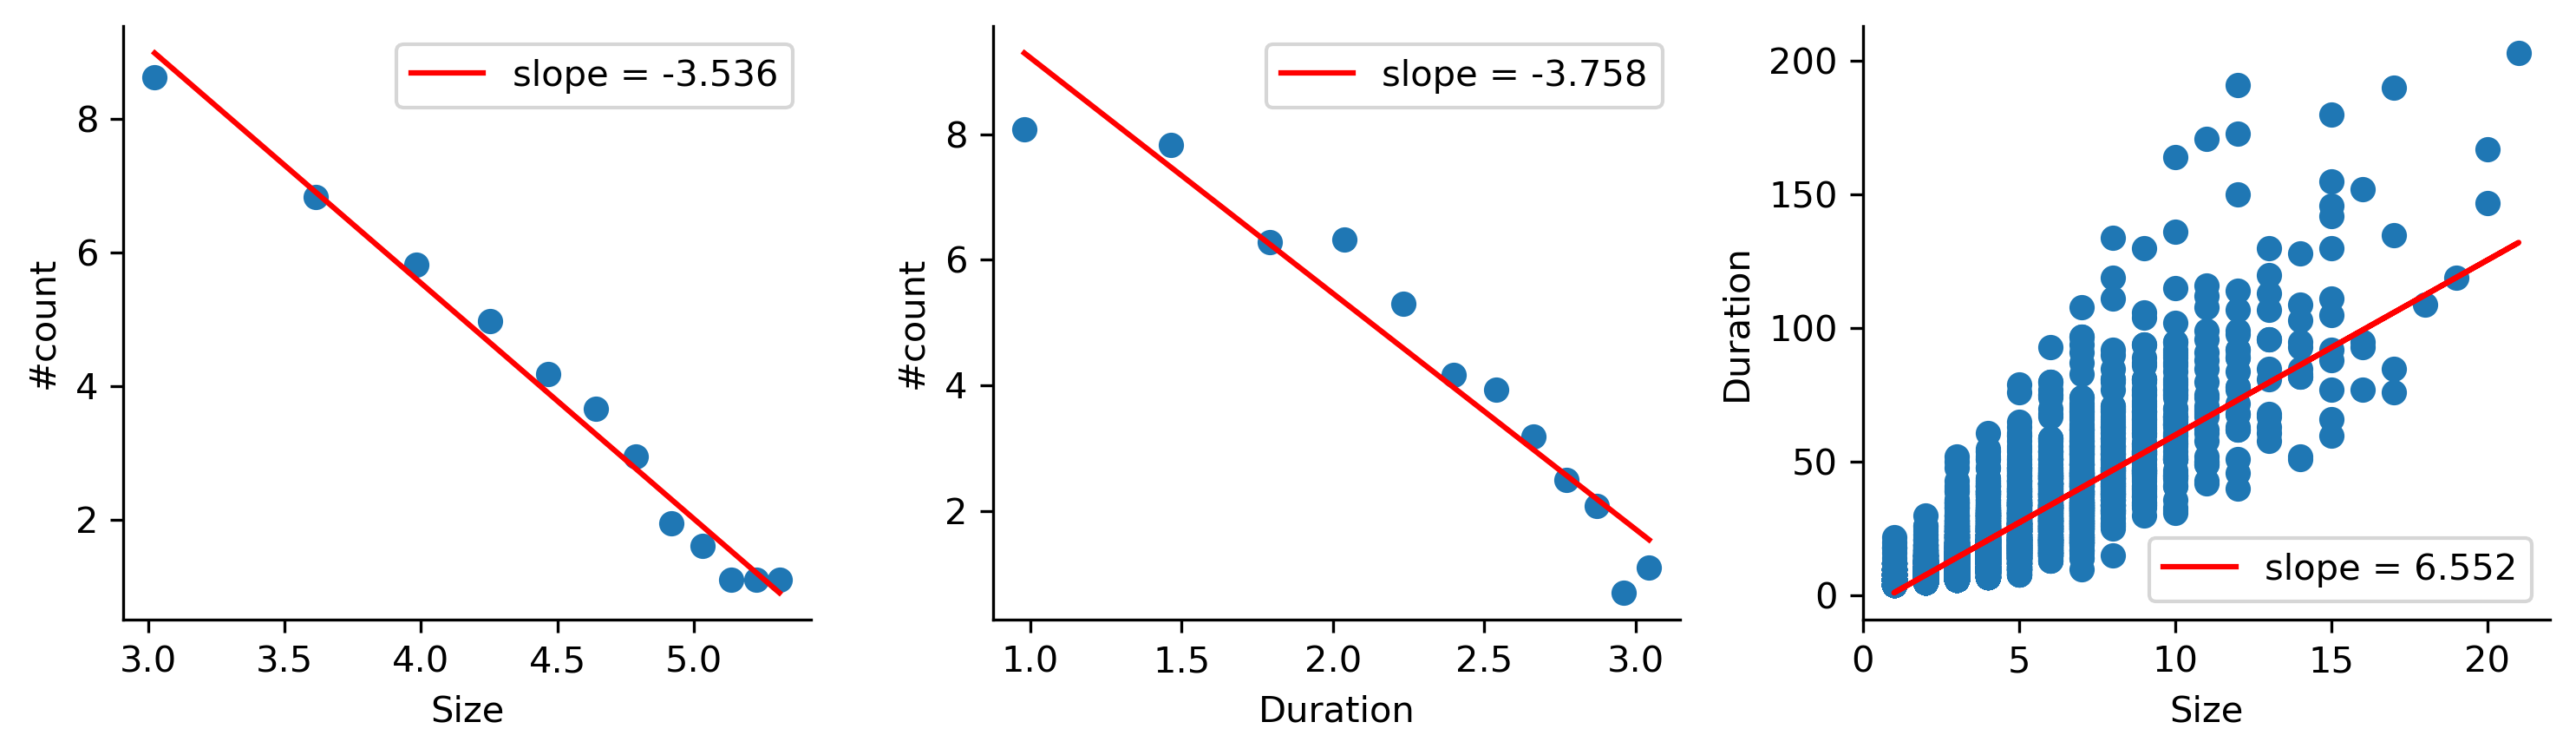

In [49]:
n_bins = 12

plt.figure(figsize=(10, 3), dpi=300)
ax = plt.subplot(1, 3, 1)
n, x = np.histogram(nsize, n_bins)
plt.scatter(np.log(x[1:]), np.log(n))
p = np.polyfit(np.log(x[1:]), np.log(n), 1)
plt.plot(np.log(x[1:]), p[0] * np.log(x[1:]) + p[1], label=f"slope = {p[0]:.3f}", c="r")
plt.legend()
plt.xlabel("Size")
plt.ylabel("#count")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

ax = plt.subplot(1, 3, 2)
nt, xt = np.histogram(ndur, n_bins)
plt.scatter(np.log(xt[1:]), np.log(nt))
p = np.polyfit(np.log(xt[1:]), np.log(nt), 1)
plt.plot(np.log(xt[1:]), p[0] * np.log(xt[1:]) + p[1], label=f"slope = {p[0]:.3f}", c="r")
plt.legend()
plt.xlabel("Duration")
plt.ylabel("#count")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

ax = plt.subplot(1, 3, 3)
plt.scatter(ndur, nsize)
p = np.polyfit(ndur, nsize, 1)
plt.plot(ndur, p[0] * ndur + p[1], label=f"slope = {p[0]:.3f}", c="r")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Duration")
plt.tight_layout()
[ax.spines[key].set_visible(False) for key in ["top", "right"]];

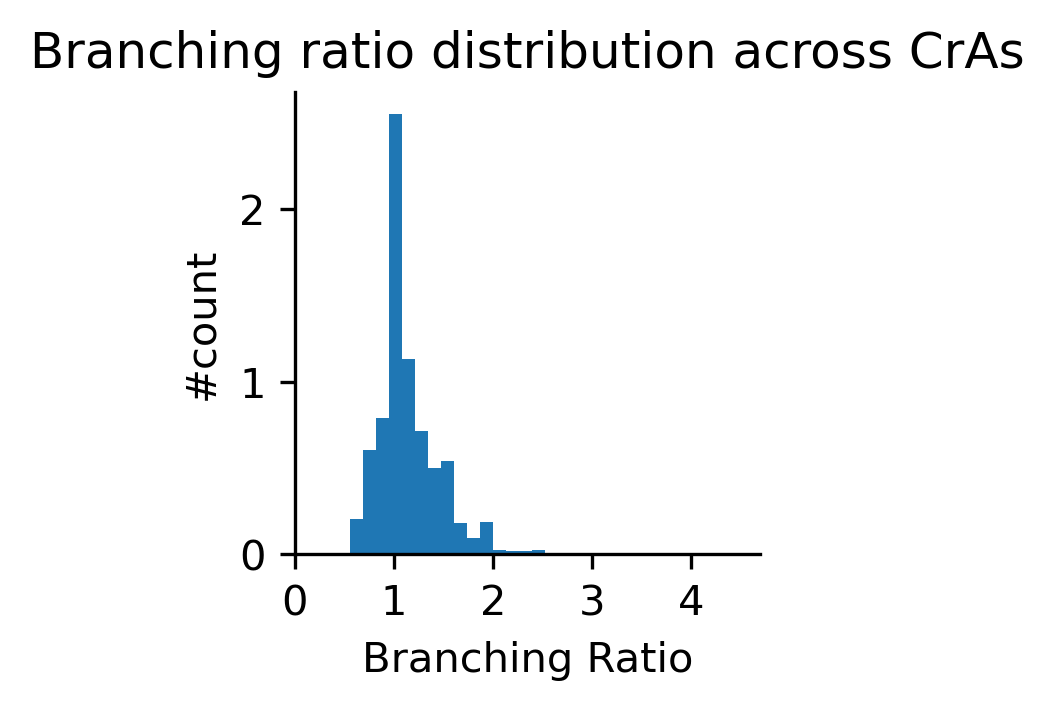

In [54]:
plt.figure(figsize=(2, 2), dpi=300)
ax = plt.subplot(111)
plt.hist(sigma, 30, density=True)
plt.xlabel("Branching Ratio")
plt.ylabel("#count")
plt.xticks([0, 1, 2, 3, 4])
plt.title("Branching ratio distribution across CrAs")
[ax.spines[key].set_visible(False) for key in ["top", "right"]];

In [28]:
n_bins = 15

slope_size = np.empty_like(unique_areas, dtype=float)
slope_dur = np.empty_like(unique_areas, dtype=float)
betas = np.empty_like(unique_areas, dtype=float)
sigmas = np.empty_like(unique_areas, dtype=float)
R = np.empty_like(unique_areas, dtype=float)

pos = 0

for roi in tqdm(unique_areas):

    # Get sizes and durations
    nsize, ndur, sigma = compute_sizes_durations(areas, times, roi=roi)

    df = (
        pd.DataFrame(np.stack((ndur, nsize), 1), columns=["duration", "sizes"])
        .groupby("duration")
        .mean("sizes")
        .reset_index()
    )

    sigmas[pos] = np.mean(sigma)

    # P(SIZE)
    Psize, xsize = np.histogram(nsize, n_bins)
    # P(DURATION)
    Pdur, xdur = np.histogram(ndur, n_bins)

    Psize = Psize + 1e-10
    Pdur = Pdur + 1e-10

    slope_size[pos] = np.polyfit(np.log(xsize[1:]), np.log(Psize), 1)[0]
    slope_dur[pos] = np.polyfit(np.log(xdur[1:]), np.log(Pdur), 1)[0]
    betas[pos] = np.polyfit( np.log(df.duration[:-2]), np.log(df.sizes[:-2]), 1)[0]
    out = spearmanr(np.log(ndur), np.log(nsize))
    R[pos] = out.statistic * (out.pvalue < 0.01)
    pos = pos + 1

  0%|                                                                  | 0/26 [00:00<?, ?it/s]


TypeError: expected non-empty vector for x

In [ ]:
slope_size = node_xr_remove_sca(
    xr.DataArray(slope_size, dims=("roi"), coords=(unique_areas,))
)
slope_dur = node_xr_remove_sca(
    xr.DataArray(slope_dur, dims=("roi"), coords=(unique_areas,))
)
betas = node_xr_remove_sca(xr.DataArray(betas, dims=("roi"), coords=(unique_areas,)))
sigmas = node_xr_remove_sca(xr.DataArray(sigmas, dims=("roi"), coords=(unique_areas,)))
R = node_xr_remove_sca(xr.DataArray(R, dims=("roi"), coords=(unique_areas,)))

In [ ]:
def plot_brain_areas(ax, ax_cbar, values, vmin=0, vmax=1, colormap="hot_r"):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas_dict = get_areas()

    area_no = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    areas = values.roi.data  # np.asarray([area for area in areas_dict.keys()])
    areas = [a.lower() for a in areas]
    fmap = flatmap(values.data, areas)

    fmap.plot(
        ax,
        ax_colorbar=ax_cbar,
        cbar_title="",
        alpha=0.4,
        colormap=colormap,
        colors=None,
        vmin=vmin,
        vmax=vmax,
    )

In [ ]:
path = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/power")

p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [ ]:
fig, axd = plt.subplot_mosaic(
    [["flatmap", "colorbar"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1, 0.05],
)
plot_brain_areas(
    axd["flatmap"],
    axd["colorbar"],
    -slope_size.sel(roi=t_pow.roi),
    vmin=0,
    vmax=10,
    colormap="hot_r",
)
plt.title("SLOPE SIZE")

In [ ]:
fig, axd = plt.subplot_mosaic(
    [["flatmap", "colorbar"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1, 0.05],
)
plot_brain_areas(
    axd["flatmap"],
    axd["colorbar"],
    -slope_dur.sel(roi=t_pow.roi),
    vmin=0,
    vmax=10,
    colormap="hot_r",
)
plt.title("SLOPE DURATION")

In [ ]:
fig, axd = plt.subplot_mosaic(
    [["flatmap", "colorbar"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1, 0.05],
)
plot_brain_areas(
    axd["flatmap"],
    axd["colorbar"],
    (slope_dur.sel(roi=t_pow.roi) - 1) / (slope_size.sel(roi=t_pow.roi) - 1),
    vmin=0,
    vmax=1.5,
    colormap="hot_r",
)
plt.title("(SLOPE DURATION - 1) / (SLOPE SIZE - 1)")

In [ ]:
fig, axd = plt.subplot_mosaic(
    [["flatmap", "colorbar"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1, 0.05],
)
plot_brain_areas(
    axd["flatmap"],
    axd["colorbar"],
    betas.sel(roi=t_pow.roi),
    vmin=0,
    vmax=1.,
    colormap="hot_r",
)
plt.title("BETA CRACKLING")

In [ ]:
 betas.sel(roi=t_pow.roi)

In [ ]:
fig, axd = plt.subplot_mosaic(
    [["flatmap", "colorbar"]],
    layout="constrained",
    # "image" will contain a square image. We fine-tune the width so that
    # there is no excess horizontal or vertical margin around the image.
    width_ratios=[1, 0.05],
)
plot_brain_areas(
    axd["flatmap"],
    axd["colorbar"],
    R.sel(roi=t_pow.roi),
    vmin=0.75,
    vmax=1.0,
    colormap="hot_r",
)
plt.title("BETA CRACKLING")

In [ ]:
np.polyfit(df.duration[:-2], df.sizes[:-2], 1)